In [4]:
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt
#from statsmodels.tsa.stattools import adfuller
import numpy as np

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/7a/81/dae7e14042e74da658c3336ab9799128e09a1ee03964f2d89630b5d12106/matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/6b/6a/7833cfae2c1e63d1d8875a50fd23371394f540ce809d7383550681a1fa64/contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/cb/98/d4bc42d43392982eecaaca117d79845734d675219680cd43070bb001bc1f/fonttools-4.57.0-cp312-cp312-m

In [8]:
files = ["./round-1-island-data-bottle/prices_round_1_day_-2.csv",
         "./round-1-island-data-bottle/prices_round_1_day_-1.csv",
         "./round-1-island-data-bottle/prices_round_1_day_0.csv",
         ]

dfs = []

for file in files:
    tmp_df = pd.read_csv(file, sep=';')
    dfs.append(tmp_df)

df = pd.concat(dfs, ignore_index=True)
df["global_timestamp"] = (df["day"] + 2) * 1_000_000 + df["timestamp"]

In [21]:
df.sort_values("global_timestamp", inplace=True)

df.drop(columns=["day", "mid_price", "profit_and_loss", "timestamp"], inplace = True, errors = "ignore")

bid_cols = [col for col in df.columns if col.startswith("bid_price_")]
ask_cols = [col for col in df.columns if col.startswith("ask_price_")]

def get_lowest_bid(row):
    bids = [row[b] for b in bid_cols if pd.notnull(row[b])]
    if not bids:
        return None
    return min(bids)

def get_highest_ask(row):
    asks = [row[a] for a in ask_cols if pd.notnull(row[a])]
    if not asks:
        return None
    return max(asks)

df["lowest_bid"] = df.apply(get_lowest_bid, axis=1)
df["highest_ask"] = df.apply(get_highest_ask, axis=1)
df["fair_value"] = (df["lowest_bid"] + df["highest_ask"]) / 2.0

df_kelp = df[df["product"] == "KELP"].copy()
df_squid = df[df["product"] == "SQUID_INK"].copy()

mean_kelp = df_kelp["fair_value"].mean()
mean_squid = df_squid["fair_value"].mean()
std_kelp = df_kelp["fair_value"].std()
std_squid = df_squid["fair_value"].std()

#df_kelp["fair_value"] = df_kelp["fair_value"] - mean_kelp
#df_squid["fair_value"] = df_squid["fair_value"] - mean_squid

# derek's scaling and alingment that supports the pair trading algorithm
#df_squid["fair_value"] = (-1 * df_squid["fair_value"]) + 2000
#df_kelp["fair_value"] = df_kelp["fair_value"] * (std_squid / std_kelp) + 2000


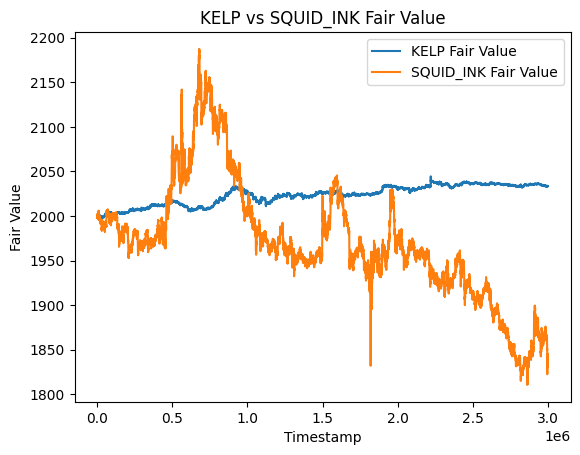

In [22]:
plt.figure()
plt.plot(df_kelp["global_timestamp"], df_kelp["fair_value"], label="KELP Fair Value")
plt.plot(df_squid["global_timestamp"], df_squid["fair_value"], label="SQUID_INK Fair Value")

#plt.axhline(y=2000, label="Mean Fair Value")

plt.xlabel("Timestamp")
plt.ylabel("Fair Value")
plt.title("KELP vs SQUID_INK Fair Value")
plt.legend()
plt.show()

In [23]:
!pip install statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [24]:
df_kelp.sort_values(by="global_timestamp", inplace=True)
df_squid.sort_values(by="global_timestamp", inplace=True)

# Get the fair_value as a numpy array (dropping missing values)
kelp_values = df_kelp["fair_value"].dropna().values
squid_values = df_squid["fair_value"].dropna().values

In [33]:
# ADF (Augmented Dickey-Fuller) test
def run_adf_test(timeseries, label):
    result = adfuller(timeseries, autolag="AIC")
    adf_statistic = result[0]
    p_value = result[1]
    used_lag = result[2]
    nobs = result[3]

    print(f"\nADF Test for {label}:")
    print(f"  ADF Statistic: {adf_statistic:.4f}")
    print(f"  p-value:       {p_value:.20f}")
    print(f"  # Lags Used:   {used_lag}")
    print(f"  # Observations:{nobs}")
    
    # Interpretation based on p < 0.05 threshold
    p_threshold = 0.05
    if p_value < p_threshold:
        print(f"  --> p < {p_threshold} => Reject H0 (random walk), "
              "suggesting non-random/meaningful pattern.")
    else:
        print(f"  --> p >= {p_threshold} => Fail to Reject H0 (random walk), "
              "suggesting random/walk-like behavior.")

In [34]:
# p value is the chance of seeing data like this if the series really were a random walk.
run_adf_test(kelp_values, "KELP")
run_adf_test(squid_values, "SQUID_INK")


ADF Test for KELP:
  ADF Statistic: -1.9892
  p-value:       0.29131859302471152517
  # Lags Used:   37
  # Observations:29962
  --> p >= 0.05 => Fail to Reject H0 (random walk), suggesting random/walk-like behavior.

ADF Test for SQUID_INK:
  ADF Statistic: -1.3398
  p-value:       0.61075304975972055654
  # Lags Used:   44
  # Observations:29955
  --> p >= 0.05 => Fail to Reject H0 (random walk), suggesting random/walk-like behavior.


In [41]:
# 2) Ljung-Box Test
def run_ljung_box_test(timeseries, label, lags=10):
    # The 'lags' parameter is somewhat arbitrary; you can experiment with it.
    lb_result = acorr_ljungbox(timeseries, lags=[lags], return_df=True)
    p_value = lb_result["lb_pvalue"].iloc[0]
    test_stat = lb_result["lb_stat"].iloc[0]
    
    print(f"\nLjung-Box Test for {label} (lags={lags}):")
    print(f"  LB Statistic: {test_stat:.4f}")
    print(f"  p-value:      {p_value:.20f}")
    p_threshold = 0.05
    if p_value < p_threshold:
        print(f"  --> p < {p_threshold} => Suggests autocorrelation (non-random).")
    else:
        print(f"  --> p >= {p_threshold} => No strong evidence of autocorrelation (random-like).")

In [43]:
run_ljung_box_test(kelp_values, "KELP", lags=10)
run_ljung_box_test(squid_values, "SQUID_INK", lags=10)


Ljung-Box Test for KELP (lags=100):
  LB Statistic: 2948821.7333
  p-value:      0.00000000000000000000
  --> p < 0.05 => Suggests autocorrelation (non-random).

Ljung-Box Test for SQUID_INK (lags=100):
  LB Statistic: 2918463.8327
  p-value:      0.00000000000000000000
  --> p < 0.05 => Suggests autocorrelation (non-random).


In [44]:
# EXPLANATIONS
#High Autocorrelation: Each data point in the series closely depends on previous points—so if yesterday’s price was high, today’s price is likely high too.

#Random-Walk-Like (ADF Test): The series doesn’t settle around a constant average but keeps “wandering” over time. The ADF test can’t rule out that the series is drifting randomly.